In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
class BooksDataset:
    def __init__(self, users, ratings, books):
        self.users = users
        self.ratings = ratings
        self.books = books


    def __len__(self):
        return len(self.users)


    def __getitem__(self, idx):
        return {
            'users': torch.tensor(self.users[idx], dtype=torch.long),
            'ratings': torch.tensor(self.ratings[idx], dtype=torch.float32),
            'books': torch.tensor(self.books[idx], dtype=torch.long)
        }

In [5]:
class BookRecommender(nn.Module):
    def __init__(self, n_books, n_users):
        super().__init__()
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.book_embed = nn.Embedding(n_books, 32)
        self.out = nn.Linear(64, 1)


    def forward(self, users, books):
        user_embed = self.user_embed(users)
        book_embed = self.book_embed(books)
        output = torch.cat([user_embed, book_embed], dim=1) 
        output = self.out(output)

        return output

In [6]:
ratings_df = pd.read_csv('main_dataset/updated_ratings.csv')
ratings_df

,user_id,isbn,rating
0,276727,0446520802,0.0
1,276746,0425115801,0.0
2,276746,0449006522,0.0
3,276746,0553561618,0.0
4,276746,055356451X,0.0
...,...,...,...
467095,276704,0441007813,0.0
467096,276704,0446353957,0.0
467097,276704,0446605409,0.0
467098,276709,0515107662,5.0


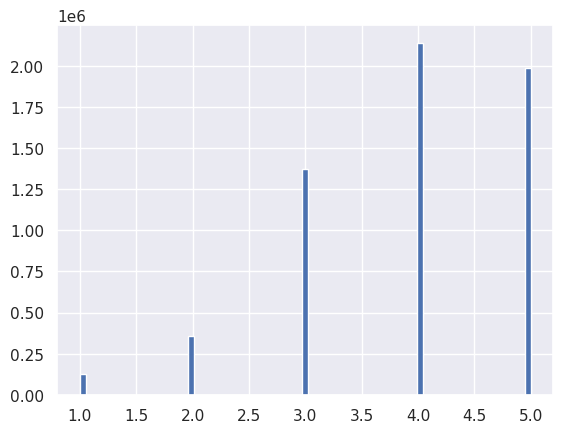

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3
...,...,...,...
5976474,49925,510,5
5976475,49925,528,4
5976476,49925,722,4
5976477,49925,949,5


In [136]:
ratings_goodreads = pd.read_csv('datasets/ds_goodbooks10k/ratings.csv')
plt.hist(ratings_goodreads["rating"], bins=75)
plt.show()
ratings_goodreads

In [7]:
# Correct each unique user_id and isbn to 0 based indexes for the NN to process properly as they are strings

lbl_userid = preprocessing.LabelEncoder()
lbl_isbn = preprocessing.LabelEncoder()
ratings_df["user_id"] = lbl_userid.fit_transform(ratings_df["user_id"].values)
ratings_df["isbn"] = lbl_isbn.fit_transform(ratings_df["isbn"].values)

ratings_df = ratings_df[ratings_df["rating"] != 0]
ratings_df

,user_id,isbn,rating
6,53992,40226,4.0
7,53993,43448,3.0
8,53994,40924,4.0
9,53995,28356,2.5
11,53996,17298,2.5
...,...,...,...
467083,53985,51274,5.0
467084,53985,52819,3.0
467094,53987,10758,3.0
467098,53988,31174,5.0


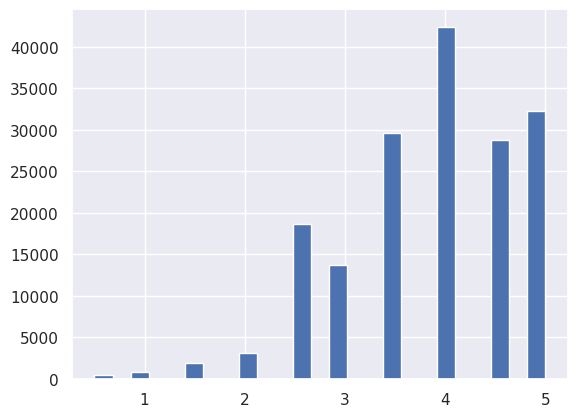

In [8]:
plt.hist(ratings_df["rating"], 25)
plt.show()

In [9]:
train, test = model_selection.train_test_split(
    ratings_df, test_size=0.2, random_state=42, stratify=ratings_df["rating"].values
    )

In [10]:
train_ds = BooksDataset(
    users=train["user_id"].values,
    books=train["isbn"].values,
    ratings=train["rating"].values
    )

test_ds = BooksDataset(
    users=test["user_id"].values,
    books=test["isbn"].values,
    ratings=test["rating"].values
    )

In [17]:
train_dl = DataLoader(train_ds, batch_size=50, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=50, shuffle=True, num_workers=2)

## Train on the ratings_df

In [13]:
max_user_index = max(train["user_id"].max(), test["user_id"].max())
max_book_index = max(train["isbn"].max(), test["isbn"].max())
print("Max User Index:", max_user_index)
print("Max Book Index:", max_book_index)

plot_steps, print_steps = 1000, 1000
step_count = 0

epochs = 3
num_folds = 3
lr = 0.001
gamma = 0.999
sch_step_size = 1

model = BookRecommender(max_book_index + 1, max_user_index + 1)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
sch = torch.optim.lr_scheduler.StepLR(optimizer, sch_step_size, gamma=gamma)
loss_function = nn.MSELoss()
kf = model_selection.KFold(n_splits=num_folds, shuffle=True)

Max User Index: 54425
Max Book Index: 58475


In [ ]:
all_losses = []
model.train()
total_loss = 0
for epoch in range(epochs):
    for i, batch in enumerate(train_dl):
        users = batch['users']
        books = batch['books']
        ratings = batch['ratings'].view(-1, 1) # Labels vector

        # Forward pass
        optimizer.zero_grad()
        outputs = model(users, books) # Predictions vector

        # Calculate the loss based on Predictions and Labels
        loss = loss_function(outputs, ratings)
        total_loss += loss.sum().item()

        # Backpropagate the loss
        loss.backward()
        optimizer.step()

        """Done with the batch training"""

        # Stats
        step_count += len(users)
        if step_count % plot_steps == 0:
            avg_loss = total_loss*1000/(plot_steps*len(users))
            print(f"Epoch: {epoch + 1}, Step: {step_count}, Avg. Loss: {avg_loss}")
            all_losses.append(avg_loss)
            total_loss = 0

    sch.step()

torch.save(model.state_dict(), "./models/model_no_cross_val.pth")

In [14]:
val_fold_losses = []
train_fold_losses = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_ds)):
    print(f"Fold {fold + 1}")
    
    train_fold = torch.utils.data.Subset(train_ds, train_idx)
    val_fold = torch.utils.data.Subset(train_ds, val_idx)

    train_dl = DataLoader(train_fold, batch_size=64, shuffle=True)
    val_dl = DataLoader(val_fold, batch_size=64, shuffle=False)

    train_fold_loss = []
    val_fold_loss = []
    for epoch in range(epochs):
        train_loss = 0
        model.train()
        for i, batch in enumerate(train_dl):
            users = batch['users']
            books = batch['books']
            ratings = batch['ratings'].view(-1, 1)

            optimizer.zero_grad()
            outputs = model(users, books)

            loss = loss_function(outputs, ratings)
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

        train_fold_loss.append(train_loss / len(train_dl))
        print(f"Epoch: {epoch}, Train Loss: {train_loss / len(train_dl)}")

        # Update learning rate scheduler
        sch.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dl:
                users = batch['users']
                books = batch['books']
                ratings = batch['ratings'].view(-1, 1)

                outputs = model(users, books)
                val_loss += loss_function(outputs, ratings).item()

        val_fold_loss.append(val_loss / len(val_dl))
        print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_dl)}")

    train_fold_losses.append(train_fold_loss)
    val_fold_losses.append(val_fold_loss)

# Compute average validation loss across all folds
avg_val_losses = np.mean(val_fold_losses, axis=0)
print("Average Validation Losses:", avg_val_losses)

avg_train_losses = np.mean(train_fold_losses, axis=0)
print("Average Validation Losses:", avg_train_losses)

torch.save(model.state_dict(), "./models/model_cross_val_3folds.pth")

Fold 1
Epoch: 0, Train Loss: 9.337340964285355
Epoch: 0, Validation Loss: 4.785288884320073
Epoch: 1, Train Loss: 2.9797408598261836
Epoch: 1, Validation Loss: 2.1018803162947712
Epoch: 2, Train Loss: 1.3610088953009531
Epoch: 2, Validation Loss: 1.2016154253782507
Fold 2
Epoch: 0, Train Loss: 0.8922844136851793
Epoch: 0, Validation Loss: 0.7287079608223958
Epoch: 1, Train Loss: 0.682407219337518
Epoch: 1, Validation Loss: 0.6771334580785735
Epoch: 2, Train Loss: 0.6152279772405518
Epoch: 2, Validation Loss: 0.6593197363132205
Fold 3
Epoch: 0, Train Loss: 0.6111715051694123
Epoch: 0, Validation Loss: 0.5392136150065747
Epoch: 1, Train Loss: 0.5505679139253481
Epoch: 1, Validation Loss: 0.5334284751774878
Epoch: 2, Train Loss: 0.4982428738129372
Epoch: 2, Validation Loss: 0.539451920037163
Average Validation Losses: [2.01773682 1.10414742 0.80012903]
Average Validation Losses: [3.61359896 1.40423866 0.82482658]


Train Losses [fold:epoch]
1: [9.337340964285355, 2.9797408598261836, 1.3610088953009531]
2: [0.8922844136851793, 0.682407219337518, 0.6152279772405518]
3: [0.6111715051694123, 0.5505679139253481, 0.4982428738129372]

Validation Losses [fold:epoch]
1: [4.785288884320073, 2.1018803162947712, 1.2016154253782507]
2: [0.7287079608223958, 0.6771334580785735, 0.6593197363132205]
3: [0.5392136150065747, 0.5334284751774878, 0.539451920037163]


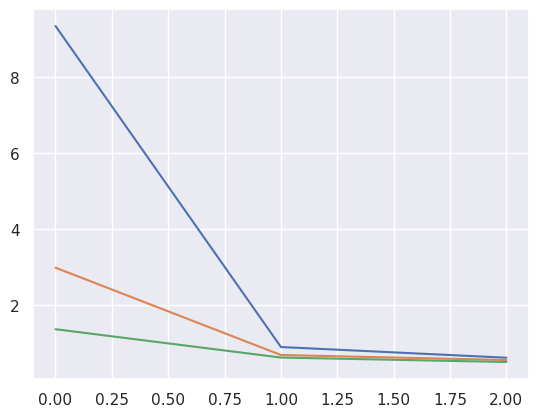

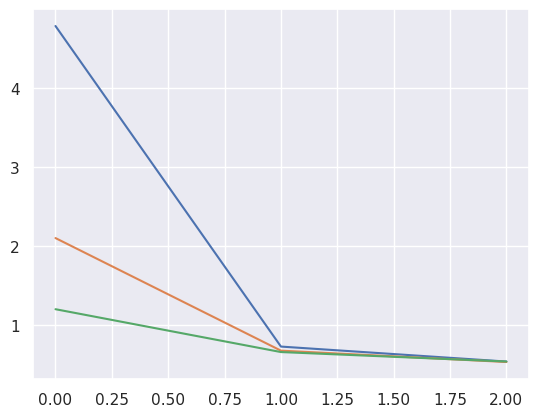

In [15]:
print("Train Losses [fold:epoch]")
for i, x in enumerate(train_fold_losses):
    print(f"{i+1}: {x}")

print("\nValidation Losses [fold:epoch]")
for i, x in enumerate(val_fold_losses):
    print(f"{i+1}: {x}")

plt.plot(train_fold_losses)
plt.show()
plt.plot(val_fold_losses)
plt.show()


Total Number of batches: 687
9
29
0.37106259097525474


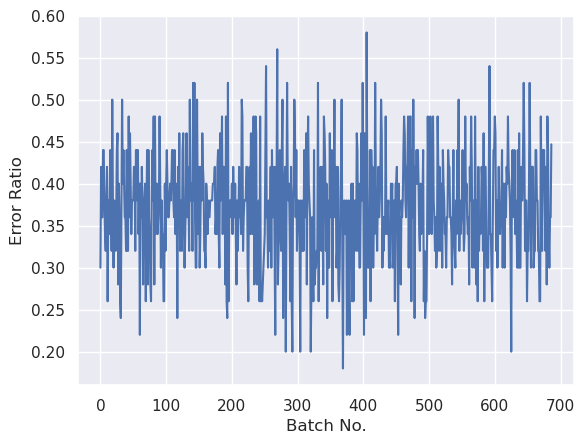

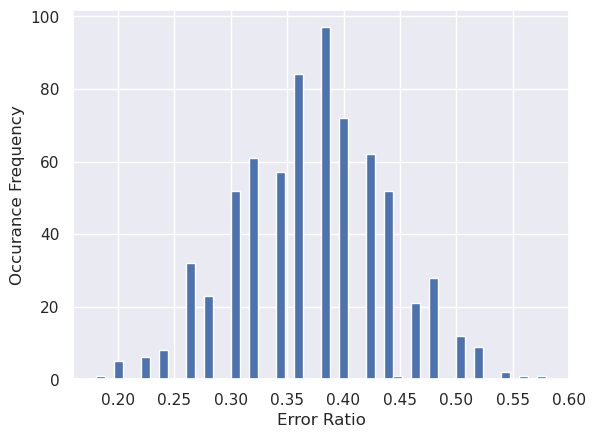

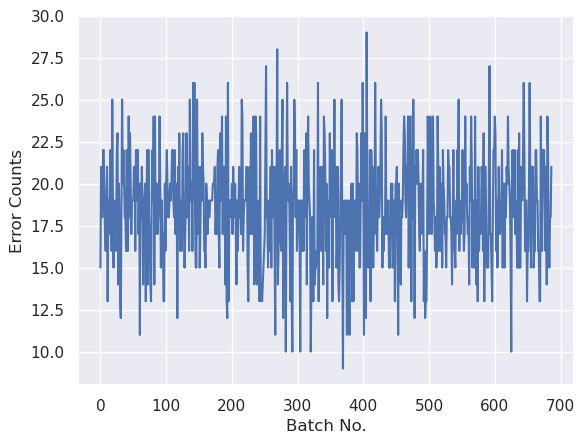

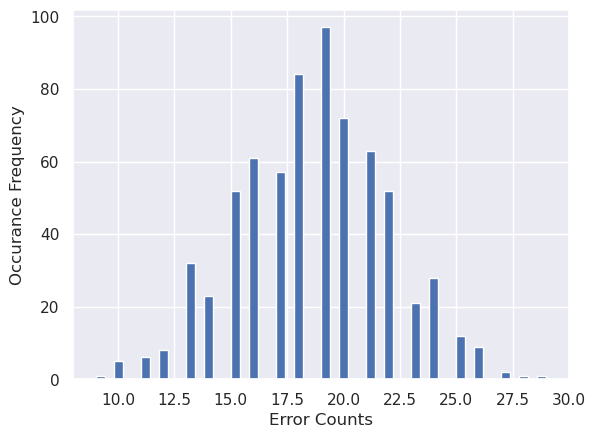

In [23]:
model_outputs = []
target_ratings = []
erred_counts = []
erred_ratios = []
erred_count = 0

model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_dl):
        users = batch['users']
        books = batch['books']
        ratings = batch['ratings'].view(-1, 1)

        output = model(users, books)
        model_outputs.append(output / len(users))
        target_ratings.append(ratings / len(users))

        for j, (o, r) in enumerate(zip(output, ratings)):
            if abs(o - r) > 0.7:
                # print(f"{i, j} : {abs(o - r).item()}")
                erred_count += 1

        erred_counts.append(erred_count)

        erred_ratio = erred_count/len(users)
        erred_ratios.append(erred_ratio)

        erred_count = 0
        # print()

print(f"Total Number of batches: {len(erred_ratios)}")
print(min(erred_counts))
print(max(erred_counts))
print(sum(erred_counts)/(50*len(erred_counts)))

plt.plot(erred_ratios)
plt.xlabel("Batch No.")
plt.ylabel("Error Ratio")
plt.show()

plt.hist(erred_ratios, bins=50)
plt.xlabel("Error Ratio")
plt.ylabel("Occurance Frequency")
plt.show()

plt.plot(erred_counts)
plt.xlabel("Batch No.")
plt.ylabel("Error Counts")
plt.show()

plt.hist(erred_counts, bins=50)
plt.xlabel("Error Counts")
plt.ylabel("Occurance Frequency")
plt.show()

At an acceptance of 0.50 error in ratings - 50% of our data is erroneous <br>
At an acceptance of 0.70 error in ratings - 40% of our data is erroneous <br>
At an acceptance of 1.00 error in ratings - 20% of our data is erroneous <br>